The backprop works, but the issue is that it doesnt't give the right result. The derivative of the the evidence w.r.t to the hyperparameters should be zero - so that we don't actually need to backprop through it. Let's check this out. First let's run a single iteration

In [1]:
# %% Imports
from jax import numpy as jnp, random
import jax
from modax.data.kdv import doublesoliton
from modax.models import Deepmod
from modax.training.utils import create_update
from flax import optim

from modax.training import train_max_iter
from modax.training.losses.utils import precision, normal_LL
from modax.utils.forward_solver import fixed_point_solver, fwd_solver, fwd_solver_simple

from flax.core import unfreeze
from flax.traverse_util import flatten_dict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'svg'

In [2]:
def update_sigma(gram, alpha, beta):
    sigma_inv = jnp.diag(alpha) + beta * gram
    L_inv = jnp.linalg.pinv(jnp.linalg.cholesky(sigma_inv))
    sigma_ = jnp.dot(L_inv.T, L_inv)
    return sigma_


def update_coeff(XT_y, beta, sigma_):
    coef_ = beta * jnp.linalg.multi_dot([sigma_, XT_y])
    return coef_


def update(prior, X, y, gram, XT_y, alpha_prior, beta_prior):
    n_samples, n_features = X.shape
    alpha, beta = prior[:-1], prior[-1]
    sigma = update_sigma(gram, alpha, beta)
    coeffs = update_coeff(XT_y, beta, sigma)

    # Update alpha and lambda
    rmse_ = jnp.sum((y - jnp.dot(X, coeffs)) ** 2)
    gamma_ = 1.0 - alpha * jnp.diag(sigma)

    # TODO: Cap alpha with some threshold.
    alpha = (gamma_ + 2.0 * alpha_prior[0]) / (
        (coeffs.squeeze() ** 2 + 2.0 * alpha_prior[1])
    )
    beta = (n_samples - gamma_.sum() + 2.0 * beta_prior[0]) / (
        rmse_ + 2.0 * beta_prior[1]
    )

    return jnp.concatenate([alpha, beta[jnp.newaxis]], axis=0)

def evidence(X, y, prior, gram, XT_y, alpha_prior, beta_prior):
    n_samples, n_features = X.shape
    alpha, beta = prior[:-1], prior[-1]

    sigma = update_sigma(gram, alpha, beta)
    coeffs = update_coeff(XT_y, beta, sigma)
    rmse_ = jnp.sum((y - jnp.dot(X, coeffs)) ** 2)

    score = jnp.sum(alpha_prior[0] * jnp.log(alpha) - alpha_prior[1] * alpha)
    score += beta_prior[0] * jnp.log(beta) - beta_prior[1] * beta
    score += 0.5 * (
        jnp.linalg.slogdet(sigma)[1]
        + n_samples * jnp.log(beta)
        + jnp.sum(jnp.log(alpha))
    )
    score -= 0.5 * (beta * rmse_ + jnp.sum(alpha * coeffs.squeeze() ** 2))

    return score.squeeze(), coeffs

Lets first create some fake input the neural network:

In [3]:
key = random.PRNGKey(42)
x = jnp.linspace(-10, 10, 100)
t = jnp.linspace(0.1, 1.0, 10)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = doublesoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[0.0, -5.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.10 * jnp.std(y) * random.normal(key, y.shape)

In [4]:
# %% Building model and params
model = Deepmod([30, 30, 30, 1])
variables = model.init(key, X)

state, params = variables.pop("params")

prediction, dt, theta, coeffs = model.apply({"params": params, **state}, X)
theta_normed = theta / jnp.linalg.norm(theta, axis=0)

In [5]:
n_samples, n_features = theta.shape
prior_params_mse = (0.0, 0.0)
tau = precision(y, prediction, *prior_params_mse)

Let's first check it out for the MSE:

In [6]:
p_mse, MSE = normal_LL(prediction, y, tau)

In [7]:
jax.grad(lambda tau: normal_LL(prediction, y, tau)[0])(tau)

DeviceArray(0., dtype=float32)

Now let's check it out for the full thing. First we calculate the derivative of p_mse wrt to the variables. If we did it correctly, it should be the same as the derivative without taking the derivative wrt tau:

In [8]:
def fwd(model, params, state, X, y, tau_diff):
    prediction = model.apply({"params": params, **state}, X)[0]
    prior_params_mse = (0.0, 0.0)
    tau = precision(y, prediction, *prior_params_mse)
    if not tau_diff:
        tau = jax.lax.stop_gradient(tau)
    return normal_LL(prediction, y, tau)[0]

In [9]:
fwd(model, params, state, X, y, True)

DeviceArray(-1033.6543, dtype=float32)

In [10]:
grads_full = jax.grad(lambda params: fwd(model, params, state, X, y, True))(params)
grads_full = flatten_dict(unfreeze(grads_full))

Now let's try it with non-differentiable tau:

In [11]:
grads_semi = jax.grad(lambda params: fwd(model, params, state, X, y, False))(params)
grads_semi = flatten_dict(unfreeze(grads_semi))

In [12]:
[jnp.sum(item) for key, item in grads_full.items()]

[DeviceArray(45.6648, dtype=float32),
 DeviceArray(-19.710003, dtype=float32),
 DeviceArray(888.5083, dtype=float32),
 DeviceArray(-1827.4893, dtype=float32),
 DeviceArray(-1641.5287, dtype=float32),
 DeviceArray(755.30005, dtype=float32),
 DeviceArray(738.9263, dtype=float32),
 DeviceArray(-611.104, dtype=float32)]

In [13]:
[jnp.sum(item) for key, item in grads_semi.items()]

[DeviceArray(45.6648, dtype=float32),
 DeviceArray(-19.710003, dtype=float32),
 DeviceArray(888.5083, dtype=float32),
 DeviceArray(-1827.4893, dtype=float32),
 DeviceArray(-1641.5287, dtype=float32),
 DeviceArray(755.30005, dtype=float32),
 DeviceArray(738.9263, dtype=float32),
 DeviceArray(-611.104, dtype=float32)]

Like we expected - it doesnt make a difference. Now let's chec this for the evidence. We have two hyperparameters - alpha and beta. Let's start with the easiest - beta

In [14]:
alpha_prior = (1e-6, 1e-6)
beta_prior = (n_samples / 2, n_samples / (2 * jax.lax.stop_gradient(tau)))

In [15]:
n_samples, n_features = theta_normed.shape
norm_weight = jnp.concatenate((jnp.ones((n_features,)), jnp.zeros((1,))), axis=0)
prior_init = jnp.concatenate([jnp.ones((n_features,)), (1.0 / (jnp.var(dt) + 1e-7))[jnp.newaxis]], axis=0)
gram = jnp.dot(theta_normed.T, theta_normed)
XT_y = jnp.dot(theta_normed.T, dt)

tol = 1e-3
max_iter = 5000 # low to keep it manageable

Now let's run a forward pass:

In [16]:
prior_params, metrics = fixed_point_solver(
    update,
    (theta_normed, dt, gram, XT_y, alpha_prior, beta_prior),
    prior_init,
    norm_weight,
    tol=tol,
    max_iter=max_iter,
)

In [17]:
print(prior_params, metrics)

[3.8262684e+01 1.4370857e+03 1.5917935e+00 1.4656094e+03 3.5256845e-01
 1.3945281e+03 1.0429993e+03 1.2461078e+03 8.3052118e+02 1.3493051e+03
 8.2142828e+02 1.3354498e+03 4.2957764e+00] (DeviceArray(5000, dtype=int32), DeviceArray(48.691433, dtype=float32))


Since we concatenated alpha and beta we take derivative to both at the same time -

In [18]:
jax.grad(lambda prior: evidence(theta_normed, dt, prior, gram, XT_y, alpha_prior, beta_prior)[0])(prior_params)

DeviceArray([ 2.98539860e-10,  3.15826334e-08, -2.00414490e-07,
             -1.01658015e-08, -6.96868483e-07, -5.32889111e-09,
              8.49975201e-10, -2.37622089e-10, -1.27095889e-10,
             -3.70641851e-11,  2.93686186e-10, -1.16686549e-10,
             -1.52587891e-05], dtype=float32)

That's super small, as it should be :) Let's plot it as a function of iterations - 

In [19]:
def devidence_dprior(its):
    prior_params, metrics = fixed_point_solver(
    update,
    (theta_normed, dt, gram, XT_y, alpha_prior, beta_prior),
    prior_init,
    norm_weight,
    tol=tol,
    max_iter=its)
    dprior = jax.grad(lambda prior: evidence(theta_normed, dt, prior, gram, XT_y, alpha_prior, beta_prior)[0])(prior_params)
    print(metrics)
    return dprior

In [20]:
its =  jnp.arange(500, 10000, 500)
dprior = list(map(devidence_dprior, its))

(DeviceArray(500, dtype=int32), DeviceArray(332.12283, dtype=float32))
(DeviceArray(1000, dtype=int32), DeviceArray(82.83841, dtype=float32))
(DeviceArray(1500, dtype=int32), DeviceArray(79.789246, dtype=float32))
(DeviceArray(2000, dtype=int32), DeviceArray(51.777607, dtype=float32))
(DeviceArray(2500, dtype=int32), DeviceArray(51.633156, dtype=float32))
(DeviceArray(3000, dtype=int32), DeviceArray(51.234745, dtype=float32))
(DeviceArray(3500, dtype=int32), DeviceArray(50.959534, dtype=float32))
(DeviceArray(4000, dtype=int32), DeviceArray(50.362476, dtype=float32))
(DeviceArray(4500, dtype=int32), DeviceArray(49.15433, dtype=float32))
(DeviceArray(5000, dtype=int32), DeviceArray(48.691433, dtype=float32))
(DeviceArray(5500, dtype=int32), DeviceArray(45.603207, dtype=float32))
(DeviceArray(6000, dtype=int32), DeviceArray(49.09422, dtype=float32))
(DeviceArray(6500, dtype=int32), DeviceArray(48.25819, dtype=float32))
(DeviceArray(7000, dtype=int32), DeviceArray(49.17788, dtype=float32)

In [21]:
dprior = jnp.abs(jnp.stack(dprior, axis=0))

Text(0.5, 1.0, '$\\partial \\mathcal{L}/{\\partial \\beta}$')

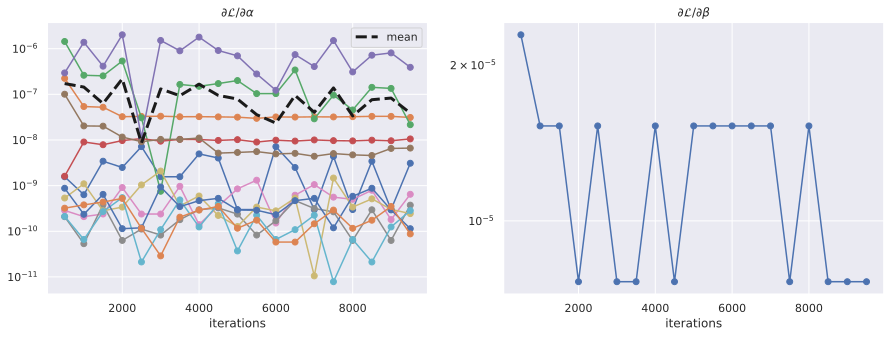

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.semilogy(its, dprior[:, :-1], 'o-')
plt.semilogy(its, jnp.mean(dprior[:, :-1], axis=1), 'k--', lw=3, label='mean')
plt.xlabel('iterations')
plt.title(r'$\partial \mathcal{L}/{\partial \alpha}$')
plt.legend()

plt.subplot(122)
plt.semilogy(its, dprior[:, -1], 'o-')
plt.xlabel('iterations')
plt.title(r'$\partial \mathcal{L}/{\partial \beta}$')

Let's zoom in on the first 2000 iterations:

In [23]:
its =  jnp.arange(100, 2000, 50)
dprior = list(map(devidence_dprior, its))

(DeviceArray(100, dtype=int32), DeviceArray(2353.7856, dtype=float32))
(DeviceArray(150, dtype=int32), DeviceArray(1582.9176, dtype=float32))
(DeviceArray(200, dtype=int32), DeviceArray(1147.3263, dtype=float32))
(DeviceArray(250, dtype=int32), DeviceArray(879.45514, dtype=float32))
(DeviceArray(300, dtype=int32), DeviceArray(699.9149, dtype=float32))
(DeviceArray(350, dtype=int32), DeviceArray(567.7075, dtype=float32))
(DeviceArray(400, dtype=int32), DeviceArray(470.18124, dtype=float32))
(DeviceArray(450, dtype=int32), DeviceArray(395.37875, dtype=float32))
(DeviceArray(500, dtype=int32), DeviceArray(332.12283, dtype=float32))
(DeviceArray(550, dtype=int32), DeviceArray(278.84628, dtype=float32))
(DeviceArray(600, dtype=int32), DeviceArray(238.54495, dtype=float32))
(DeviceArray(650, dtype=int32), DeviceArray(207.56445, dtype=float32))
(DeviceArray(700, dtype=int32), DeviceArray(179.62943, dtype=float32))
(DeviceArray(750, dtype=int32), DeviceArray(154.04265, dtype=float32))
(DeviceA

In [24]:
dprior = jnp.abs(jnp.stack(dprior, axis=0))

Text(0.5, 1.0, '$\\partial \\mathcal{L}/{\\partial \\beta}$')

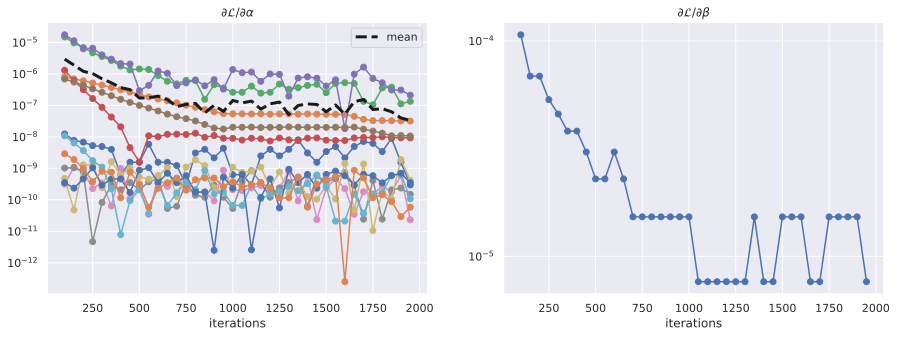

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.semilogy(its, dprior[:, :-1], 'o-')
plt.semilogy(its, jnp.mean(dprior[:, :-1], axis=1), 'k--', lw=3, label='mean')
plt.xlabel('iterations')
plt.title(r'$\partial \mathcal{L}/{\partial \alpha}$')
plt.legend()

plt.subplot(122)
plt.semilogy(its, dprior[:, -1], 'o-')
plt.xlabel('iterations')
plt.title(r'$\partial \mathcal{L}/{\partial \beta}$')

Let's take the mean over all:

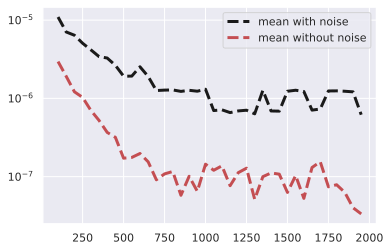

In [26]:
plt.semilogy(its, jnp.mean(dprior, axis=1), 'k--', lw=3, label='mean with noise')
plt.semilogy(its, jnp.mean(dprior[:, :-1], axis=1), 'r--', lw=3, label='mean without noise')
plt.legend()